<a href="https://colab.research.google.com/github/YilinLiu97/vae/blob/main/VAE-FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz



--2021-03-15 03:37:11--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.178
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.75.178|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  12.1MB/s    in 2.1s    

2021-03-15 03:37:14 (12.1 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-03-15 03:37:14--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.178
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

In [ ]:
import os
import gzip
import numpy as np

pwd = '/content'
images_path = os.path.join(pwd, 'train-images-idx3-ubyte.gz')
labels_path = os.path.join(pwd, 'train-labels-idx1-ubyte.gz')

test_images_path = os.path.join(pwd, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(pwd, 't10k-labels-idx1-ubyte.gz')

with gzip.open(labels_path, 'rb') as lbpath:
     labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

with gzip.open(images_path, 'rb') as imgpath:
     images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

with gzip.open(test_labels_path, 'rb') as lbpath:
     test_labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)


with gzip.open(test_images_path, 'rb') as imgpath:
     test_images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(test_labels), 784)



In [ ]:
images = images/255

In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 5000
batch_size = 128
capacity = 128
learning_rate = 1e-4
variational_beta = 1
use_gpu = True

In [ ]:
import torch
from torch.utils.data import Dataset

class train_dataset(Dataset):
  def __init__(self, images, labels):
    self.images, self.labels = np.reshape(images, (-1,28,28)), labels
    self.size = len(self.images)
  def __len__(self):
    return self.size
  def __getitem__(self, idx):
    return {'images': self.images[idx], 'labels': self.labels[idx]}

TrainData = train_dataset(images, labels)
Train_loader = DataLoader(TrainData, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

TestData = train_dataset(test_images, test_labels)
Test_loader = DataLoader(TestData, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

'''
img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = img_transform(images)
'''

'\nimg_transform = transforms.Compose([\n    transforms.ToTensor()\n])\n\ntrain_dataset = img_transform(images)\n'

In [ ]:
import torch.nn as nn
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    c = capacity
    self.conv1 = nn.Conv2d(1,c,kernel_size=4, stride=2, padding=1) 
    self.conv2 = nn.Conv2d(c, c*2, kernel_size=4, stride=2, padding=1)
    self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
    self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)
    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)
    return x_mu, x_logvar

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    c = capacity
    self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
    self.conv2 = nn.ConvTranspose2d(c*2, c, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.ConvTranspose2d(c, 1, kernel_size=4, stride=2, padding=1)

  def forward(self, x):
    #print('latent: ', x.shape)
    x = self.fc(x)
    x = x.view(x.size(0), capacity*2, 7, 7)
    x = F.relu(self.conv2(x))
    x = torch.sigmoid(self.conv1(x))

    return x

class VariationalAutoencoder(nn.Module):
  def __init__(self):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    latent_mu, latent_logvar = self.encoder(x)
    latent = self.latent_sample(latent_mu, latent_logvar)
    x_recon = self.decoder(latent)
    return x_recon, latent_mu, latent_logvar
  
  def latent_sample(self, mu, logvar):
    if self.training:
      # the reparametrization trick
      std = logvar.mul(0.5).exp_()
      eps = torch.empty_like(std)
      return eps.mul(std).add_(mu)
    else:
      return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = 0.5 * torch.sum(logvar.exp() + mu.pow(2) -1 - logvar)
    #print('recon_loss: ', recon_loss)
    #print('kldivergence: ', variational_beta * kldivergence)
    return recon_loss + variational_beta * kldivergence
    

vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1140997


In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for iteration, sample in enumerate(Train_loader):
        
        image_batch = sample['images']
        image_batch = Variable(image_batch.unsqueeze(1)).float().to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        #print('loss: ', loss)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 5000] average reconstruction error: 46271.049444
Epoch [2 / 5000] average reconstruction error: 36885.085875
Epoch [3 / 5000] average reconstruction error: 38021.558894
Epoch [4 / 5000] average reconstruction error: 38772.381438
Epoch [5 / 5000] average reconstruction error: 39176.185105
Epoch [6 / 5000] average reconstruction error: 37852.987132
Epoch [7 / 5000] average reconstruction error: 37849.856143
Epoch [8 / 5000] average reconstruction error: 38128.085438
Epoch [9 / 5000] average reconstruction error: 36064.958597
Epoch [10 / 5000] average reconstruction error: 38025.964790
Epoch [11 / 5000] average reconstruction error: 36631.625662
Epoch [12 / 5000] average reconstruction error: 37310.631842
Epoch [13 / 5000] average reconstruction error: 36944.209592
Epoch [14 / 5000] average reconstruction error: 37739.376587
Epoch [15 / 5000] average reconstruction error: 35437.170821
Epoch [16 / 5000] average reconstruction error: 37116.303118
Epoch [17 / 5000] av

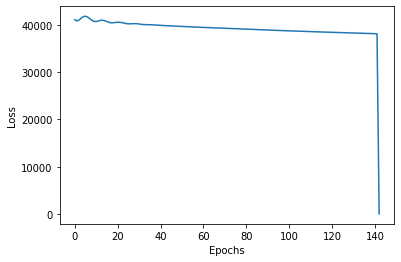

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg[10:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for iteration, sample in enumerate(Test_loader):
    
    with torch.no_grad():
    
        image_batch = sample['images']
        image_batch = Variable(image_batch.unsqueeze(1)).float().to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return default_collate([torch.as_tensor(b) for b in batch])
/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of wa

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return default_collate([torch.as_tensor(b) for b in batch])
/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of wa

Original images


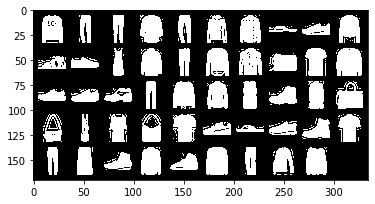

VAE reconstruction:


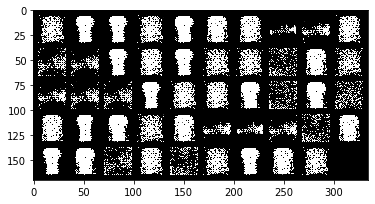

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x


def visualise_output(images, model):

    with torch.no_grad():
    
        images = Variable(images.unsqueeze(1)).float().to(device)
        out, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        out = out.cpu()
        out = to_img(out)
        np_imagegrid = torchvision.utils.make_grid(out[1:50], 10, 5).numpy()
        np_original = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        
        # First visualise the original images
        print('Original images')
        plt.imshow(np.transpose(np_original, (1, 2, 0)))
        plt.show()
        print('VAE reconstruction:')
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

sample = iter(Test_loader).next()
images, labels = sample['images'], sample['labels']




# Reconstruct and visualise the images using the vae

visualise_output(images, vae)

<class 'torch.Tensor'>


ValueError: ignored

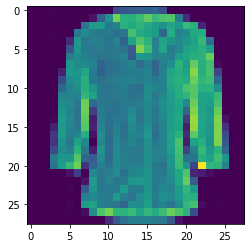

In [ ]:
z = torchvision.utils.make_grid(images[1:50],10,5)


In [ ]:
sample['images'].shape

torch.Size([128, 28, 28])

RuntimeError: ignored

tensor(2, dtype=torch.uint8)